# Setup

Se va a atacar el modelo [Inception v3](https://arxiv.org/abs/1512.00567) entrenado sobre [ImageNet](http://www.image-net.org/). Aquí se procederá a descargar dicha red.

In [1]:
import tensorflow as tf
import tensorflow.contrib.slim as slim
import tensorflow.contrib.slim.nets as nets

In [2]:
tf.logging.set_verbosity(tf.logging.ERROR)
sess = tf.InteractiveSession()

Se establece la imagen de entrada.

In [3]:
image = tf.Variable(tf.zeros((299, 299, 3)))

Se carga el modelo Inception v3.

In [4]:
def inception(image, reuse):
    preprocessed = tf.multiply(tf.subtract(tf.expand_dims(image, 0), 0.5), 2.0)
    arg_scope = nets.inception.inception_v3_arg_scope(weight_decay=0.0)
    with slim.arg_scope(arg_scope):
        logits, _ = nets.inception.inception_v3(
            preprocessed, 1001, is_training=False, reuse=reuse)
        logits = logits[:,1:] # ignorar la clase background
        probs = tf.nn.softmax(logits) # probabilidades
    return logits, probs

logits, probs = inception(image, reuse=False)

Se cargan los pesos pre-entrenados.

In [5]:
import tempfile
from urllib.request import urlretrieve
import tarfile
import os

In [6]:
data_dir = tempfile.mkdtemp()
inception_tarball, _ = urlretrieve(
    'http://download.tensorflow.org/models/inception_v3_2016_08_28.tar.gz')
tarfile.open(inception_tarball, 'r:gz').extractall(data_dir)

In [7]:
restore_vars = [
    var for var in tf.global_variables()
    if var.name.startswith('InceptionV3/')
]
saver = tf.train.Saver(restore_vars)
saver.restore(sess, os.path.join(data_dir, 'inception_v3.ckpt'))

Se escribirá el código necesario para mostrar una imagen, clasificarla y visualizar dicho resultado.

In [8]:
import json
import matplotlib.pyplot as plt

In [9]:
imagenet_json = '/home/eldar/selfdriving car/imagenet.json'
with open(imagenet_json) as f:
    imagenet_labels = json.load(f)

In [10]:
def classify(img, correct_class=None, target_class=None):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 8))
    fig.sca(ax1)
    p = sess.run(probs, feed_dict={image: img})[0]
    ax1.imshow(img)
    fig.sca(ax1)
    
    topk = list(p.argsort()[-10:][::-1])
    topprobs = p[topk]
    barlist = ax2.bar(range(10), topprobs)
    if target_class in topk:
        barlist[topk.index(target_class)].set_color('r')
    if correct_class in topk:
        barlist[topk.index(correct_class)].set_color('g')
    plt.sca(ax2)
    plt.ylim([0, 1.1])
    plt.xticks(range(10),
               [imagenet_labels[i][:15] for i in topk],
               rotation='vertical')
    fig.subplots_adjust(bottom=0.2)
    plt.show()

## Imagen de Ejemplo

Se cargará la imagen de ejemplo y se comprobará que es clasiicada por el modelo correctamente.

In [11]:
import PIL
import numpy as np

In [12]:
img_path = '/home/eldar/selfdriving car/cat.jpg'
img_class = 281
img = PIL.Image.open(img_path)
big_dim = max(img.width, img.height)
wide = img.width > img.height
new_w = 299 if not wide else int(img.width * 299 / img.height)
new_h = 299 if wide else int(img.height * 299 / img.width)
img = img.resize((new_w, new_h)).crop((0, 0, 299, 299))
img = (np.asarray(img) / 255.0).astype(np.float32)

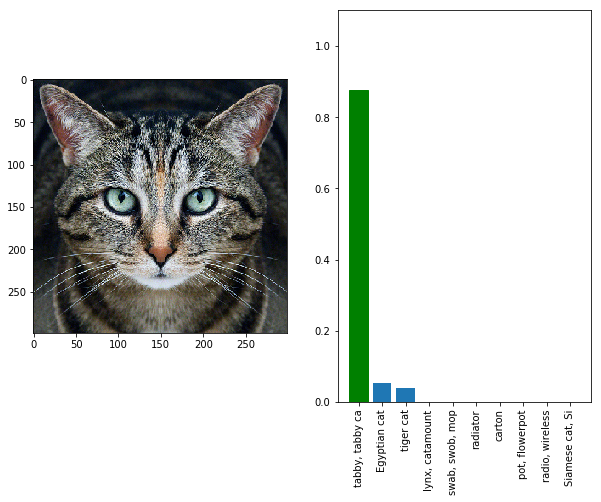

In [13]:
classify(img, correct_class=img_class)

# Ejemplos Adversarios

Dada una image $\mathbf{x}$, la red neuronal devuelve una distribución de probabilidad sobre los labels, $P(y \mid \mathbf{x})$. Cuando se construye un ejemplo adversario, se quiere encontrar un $\hat{\mathbf{x}}$ donde $\log P(\hat{y} \mid \hat{\mathbf{x}})$ sea maximizado para un label objetivo $\hat{y}$: de esa forma, nuestra entrada será erróneamente clasificada como la clase objetivo. Podemos asegurarnos de que $\hat{\mathbf{x}}$ no tenga un aspecto muy diferente de la imagen original $\mathbf{x}$ restrigiéndonos a algún rango $\ell_\infty$ con radio $\epsilon$, requiriendo que $\left\lVert \mathbf{x} - \hat{\mathbf{x}} \right\rVert_\infty \le \epsilon$.

Un ejemplo adversario es la solución a un problema restringido de optimización que se puede solucionar empleando [backpropagation](http://colah.github.io/posts/2015-08-Backprop/) y el gradiente descendente proyectado, básicamente las mismas técnicas para entrenar las propias redes. El algoritmo es el siguiente: 

Se comienza inicializando la imagen adversaria como $\hat{\mathbf{x}} \leftarrow \mathbf{x}$. A continuación, se repiten estos pasos hasta la convergencia:

1. $\hat{\mathbf{x}} \leftarrow \hat{\mathbf{x}} + \alpha \cdot \nabla \log P(\hat{y} \mid \hat{\mathbf{x}})$
2. $\hat{\mathbf{x}} \leftarrow \mathrm{clip}(\hat{\mathbf{x}}, \mathbf{x} - \epsilon, \mathbf{x} + \epsilon)$

## Inicialización

Se escribe la operación de Tensorflow para la inicialización.

In [14]:
x = tf.placeholder(tf.float32, (299, 299, 3))

x_hat = image # La imagen adversaria entrenable
assign_op = tf.assign(x_hat, x)

## Paso del Gradiente Descendente

Se escribe el paso del Gradiente Descendente para maximizar el logaritmo de la probabilidad de la clase objetivo o de forma equivalente minimizar el [cross entropy](https://en.wikipedia.org/wiki/Cross_entropy).

In [15]:
learning_rate = tf.placeholder(tf.float32, ())
y_hat = tf.placeholder(tf.int32, ())

labels = tf.one_hot(y_hat, 1000)
loss = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=[labels])
optim_step = tf.train.GradientDescentOptimizer(
    learning_rate).minimize(loss, var_list=[x_hat])

## Paso de Proyección

Se escribe el paso de proyección para mantener la imagen adversaria visualmente cercana a la imagen original. Además se acotará (clip) entre $[0, 1]$.

In [16]:
epsilon = tf.placeholder(tf.float32, ())

below = x - epsilon
above = x + epsilon
projected = tf.clip_by_value(tf.clip_by_value(x_hat, below, above), 0, 1)
with tf.control_dependencies([projected]):
    project_step = tf.assign(x_hat, projected)

## Ejecución

Se creará la imagen adversaria. Aleatoriamente se elige "guacamole" (clase 924 de imagenet) como la clase objetivo.

In [17]:
demo_epsilon = 2.0/255.0 # Una perturbación muy pequeña
demo_lr = 1e-1
demo_steps = 100
demo_target = 924 # "guacamole"

# Paso de inicialización
sess.run(assign_op, feed_dict={x: img})

# Gradiente Descendente Proyectado
for i in range(demo_steps):
    # Paso del Gradiente Descendente
    _, loss_value = sess.run(
        [optim_step, loss],
        feed_dict={learning_rate: demo_lr, y_hat: demo_target})
    # Paso de Proyección
    sess.run(project_step, feed_dict={x: img, epsilon: demo_epsilon})
    if (i+1) % 10 == 0:
        print('step %d, loss=%g' % (i+1, loss_value))
    

adv = x_hat.eval() # Obtener el ejemplo adversario

step 10, loss=4.07653
step 20, loss=0.933275
step 30, loss=0.04727
step 40, loss=0.0295432
step 50, loss=0.0224653
step 60, loss=0.0184136
step 70, loss=0.0156586
step 80, loss=0.0137761
step 90, loss=0.0123379
step 100, loss=0.0112538


Esta imagen adversaria es indistinguible de la imagen original pero es clasificada como "guacamole" con una alta probabilidad.

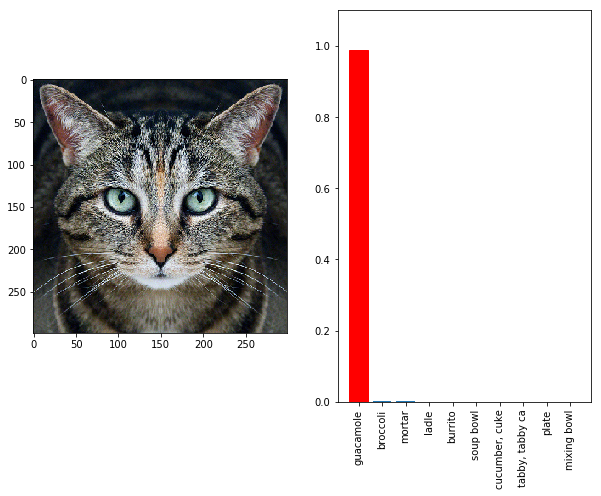

In [18]:
classify(adv, correct_class=img_class, target_class=demo_target)